<a href="https://colab.research.google.com/github/aivrm/ai/blob/main/GD_4_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%96%B4%EB%94%94%EA%B9%8C%EC%A7%80_%EC%9A%B0%EB%A0%A4%EB%B3%BC%EA%B9%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [2]:
print(np.__version__)

1.21.6


In [3]:
print(tf.__version__)

2.8.2


In [4]:
print(keras.__version__)

2.8.0


In [5]:
print(tfds.__version__)

4.6.0


---
#### 데이터셋 로딩

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True, # with_info 없으면 Error 발생
    with_info=True,     # 부가정보도 출력됨.
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteA37VDM/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteA37VDM/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [7]:
ds_info.features["label"].names[:10]

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound']

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [9]:
# 기본 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [10]:
# Augumentaion 함수
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [11]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,    # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
# make random augment function
def augment2(image,label):
    # [[YOUR CODE]]
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

---
### stanford_dogs 데이터셋 다시 로딩
tensorflow_datasets.load

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True, # a 2-tuple structure (input, label)
    shuffle_files=True,
    with_info=True,
)

In [14]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [15]:
type(num_classes)

int

---
### ImageNet 으로 PreTrained 된 ResNet_50 모델을 2개 만든다.
* no_aug_resnet50
* aug_resnet50

In [16]:
# (model) no_aug_resnet50
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# (model) aug_resnet50
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


---
### Augmentation

In [17]:
# with_aug 어디가 True인지 볼 것.
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)  # Augmentation (with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)         # Augmentation (with_aug=True)

In [18]:
ds_train_no_aug

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [19]:
ds_train_aug

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Train
* ds_train_no_aug → no_aug_resnet50 → history_resnet50_no_aug
* ds_train_aug    → aug_resnet50    → history_resnet50_aug

In [21]:
EPOCH = 1   # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

In [22]:
no_aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [23]:
history_resnet50_no_aug = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 123s 136ms/step - loss: 2.1754 - accuracy: 0.4540 - val_loss: 3.7680 - val_accuracy: 0.1646


In [24]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,   # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 112s 138ms/step - loss: 2.2864 - accuracy: 0.4308 - val_loss: 3.0058 - val_accuracy: 0.2648


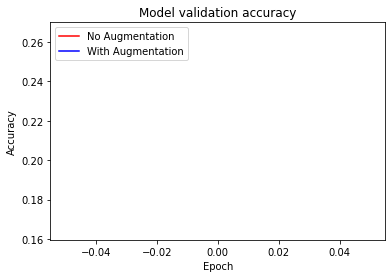

In [25]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

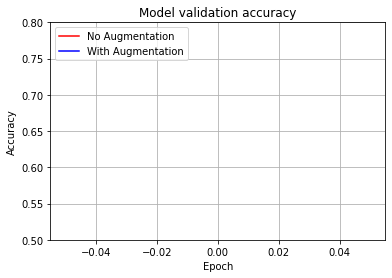

In [26]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

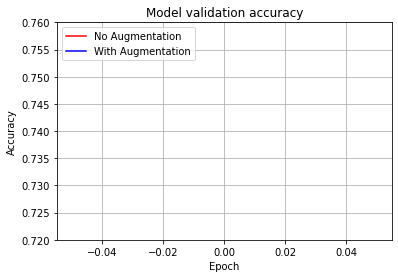

In [27]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

---
---
---

---
### Cutmix Augmentation

###### 이미지 섞기

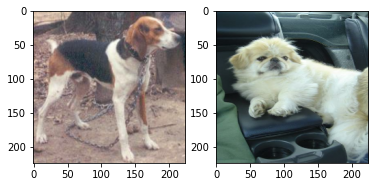

In [28]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [29]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(113, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(121, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


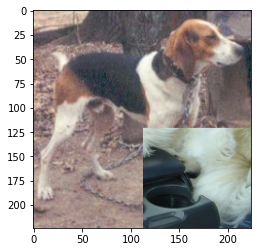

In [30]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

###### 라벨 섞기

In [31]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.22785795, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.77214205, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [32]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


---
### Mixup Augmentation

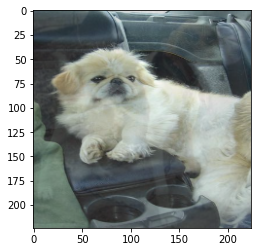

tf.Tensor(
[0.         0.         0.         0.78635263 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.21364737 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [33]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [34]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

---
### CutMix 또는 Mixup 비교실험 하기

---

### preProcessing & Augmentation

In [35]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, ds_name, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    print('---',ds_name,'---')
    
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        print('111')
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        print('222')
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        print('333')
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        print('444')
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        print('555')
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

---
### stanford_dogs 데이터셋 또 다시 로딩
tensorflow_datasets.load

In [49]:
(ds_train_2, ds_test_2), ds_info_2 = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,     # a 2-tuple structure (input, label)
    shuffle_files=True,
    with_info=True,
)

In [50]:
ds_train_no_aug_oh = apply_normalize_on_dataset(ds_train_2, 'ds_train_no_aug_oh', with_aug=False)
ds_train_aug_oh = apply_normalize_on_dataset(ds_train_2, 'ds_train_aug_oh', with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train_2, 'ds_train_cutmix', with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train_2, 'ds_train_mixup', with_mixup=True)
ds_test_oh = apply_normalize_on_dataset(ds_test_2, 'ds_test_oh', is_test=True)

--- ds_train_no_aug_oh ---
444
555
--- ds_train_aug_oh ---
111
444
555
--- ds_train_cutmix ---
222
555
--- ds_train_mixup ---
333
555
--- ds_test_oh ---
444


In [51]:
ds_train_no_aug_oh

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [52]:
ds_train_aug_oh

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

In [53]:
ds_train_cutmix

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>

In [54]:
ds_train_mixup

<PrefetchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))>

In [55]:
ds_test_2

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [56]:
ds_test_oh

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))>

#### ResNet_50 모델을 4개 만든다.
* no_aug_resnet50_2
* aug_resnet50_2
* cutmix_resnet50
* mixup_resnet50

In [57]:
# (model) no_aug_resnet50_2
no_aug_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# (model) aug_resnet50_2
aug_resnet50_2 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# (model) cutmix_resnet50
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# (model) mixup_resnet50
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [58]:
tf.random.set_seed(22)

no_aug_resnet50_2.compile(
    loss='categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

aug_resnet50_2.compile(
    loss='categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    #optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    # optimizer=tf.keras.optimizers.SGD(lr=0.01),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

### Train
* ds_train_cutmix → cutmix_resnet50  → history_resnet50_cutmix
* ds_train_mixup  → mixup_resnet50   → history_resnet50_mixup

In [59]:
history_resnet50_no_aug_2 = no_aug_resnet50_2.fit(
    ds_train_no_aug_oh,
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 112s 138ms/step - loss: 2.1940 - accuracy: 0.4449 - val_loss: 2.9151 - val_accuracy: 0.2814


In [60]:
history_resnet50_aug_2 = aug_resnet50_2.fit(
    ds_train_aug_oh,    # Augmentation
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 113s 140ms/step - loss: 2.2916 - accuracy: 0.4287 - val_loss: 2.8639 - val_accuracy: 0.2895


In [61]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix,    # CUTMIX Augmentation
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 115s 141ms/step - loss: 3.8345 - accuracy: 0.2107 - val_loss: 3.6075 - val_accuracy: 0.1736


In [62]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup,     # MIXUP Augmentation
    steps_per_epoch=int(ds_info_2.splits['train'].num_examples/16),
    validation_steps=int(ds_info_2.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_oh,
    verbose=1,
    use_multiprocessing=True,
)

750/750 [==============================] - 114s 141ms/step - loss: 3.7045 - accuracy: 0.2498 - val_loss: 3.7680 - val_accuracy: 0.1474


### 성능 평가

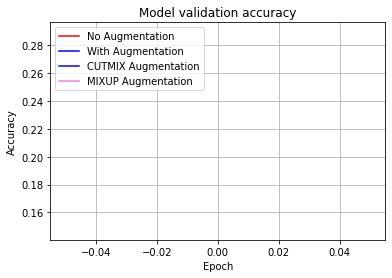

In [63]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

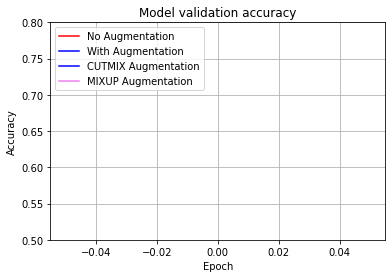

In [64]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

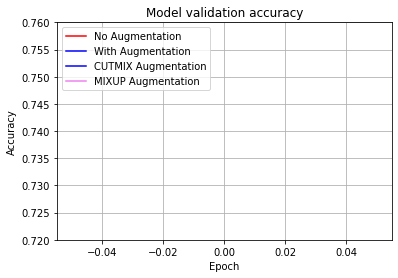

In [65]:
plt.plot(history_resnet50_no_aug_2.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug_2.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], color='violet')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'CUTMIX Augmentation', 'MIXUP Augmentation'], loc='upper left')
plt.grid(True)
#plt.ylim(0.50, 0.80)   # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
plt.ylim(0.72, 0.76)   # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### 회고